In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers




In [4]:
from pathlib import Path


In [36]:
data_train_path = '../Fruits_Vegetables/train'
data_test_path = '../Fruits_Vegetables/test'
data_valid_path = '../Fruits_Vegetables/validation'

In [38]:

def proc_img(filepath_list):
    """Create a DataFrame with the filepath and the labels of the pictures"""
    filepaths = pd.Series(filepath_list, name='Filepath').astype(str)

    # Ensure all paths have at least two parts
    labels = [path.replace("\\", "/").split("/")[-2] if len(path.replace("\\", "/").split("/")) >= 2 else "unknown"
              for path in filepaths]

    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepaths, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

# Use pathlib to get all image file paths
train_files = list(Path(data_train_path).rglob("*.jpg"))
test_files = list(Path(data_test_path).rglob("*.jpg"))
val_files = list(Path(data_valid_path).rglob("*.jpg"))

# Create DataFrames
train_df = proc_img(train_files)
test_df = proc_img(test_files)
val_df = proc_img(val_files)


In [40]:
train_df.head

<bound method NDFrame.head of                                                Filepath          Label
0       ..\Fruits_Vegetables\train\spinach\Image_35.jpg        spinach
1          ..\Fruits_Vegetables\train\pear\Image_46.jpg           pear
2        ..\Fruits_Vegetables\train\spinach\Image_1.jpg        spinach
3        ..\Fruits_Vegetables\train\carrot\Image_81.jpg         carrot
4       ..\Fruits_Vegetables\train\raddish\Image_18.jpg        raddish
...                                                 ...            ...
2850      ..\Fruits_Vegetables\train\mango\Image_44.jpg          mango
2851     ..\Fruits_Vegetables\train\ginger\Image_33.jpg         ginger
2852      ..\Fruits_Vegetables\train\mango\Image_30.jpg          mango
2853  ..\Fruits_Vegetables\train\chilli pepper\Image...  chilli pepper
2854       ..\Fruits_Vegetables\train\corn\Image_90.jpg           corn

[2855 rows x 2 columns]>

In [84]:
train_df.to_csv('labels.csv',index=False)

In [41]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['spinach' 'pear' 'carrot' 'raddish' 'lemon' 'sweetcorn' 'ginger' 'potato'
 'soy beans' 'tomato' 'mango' 'garlic' 'capsicum' 'turnip' 'chilli pepper'
 'lettuce' 'corn' 'pineapple' 'grapes' 'beetroot' 'peas' 'banana'
 'pomegranate' 'kiwi' 'jalepeno' 'orange' 'onion' 'cabbage' 'bell pepper'
 'eggplant' 'watermelon' 'sweetpotato' 'cucumber' 'paprika' 'cauliflower'
 'apple']


In [42]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,..\Fruits_Vegetables\train\spinach\Image_35.jpg,spinach
1,..\Fruits_Vegetables\train\pear\Image_46.jpg,pear
2,..\Fruits_Vegetables\train\spinach\Image_1.jpg,spinach
3,..\Fruits_Vegetables\train\carrot\Image_81.jpg,carrot
4,..\Fruits_Vegetables\train\raddish\Image_18.jpg,raddish


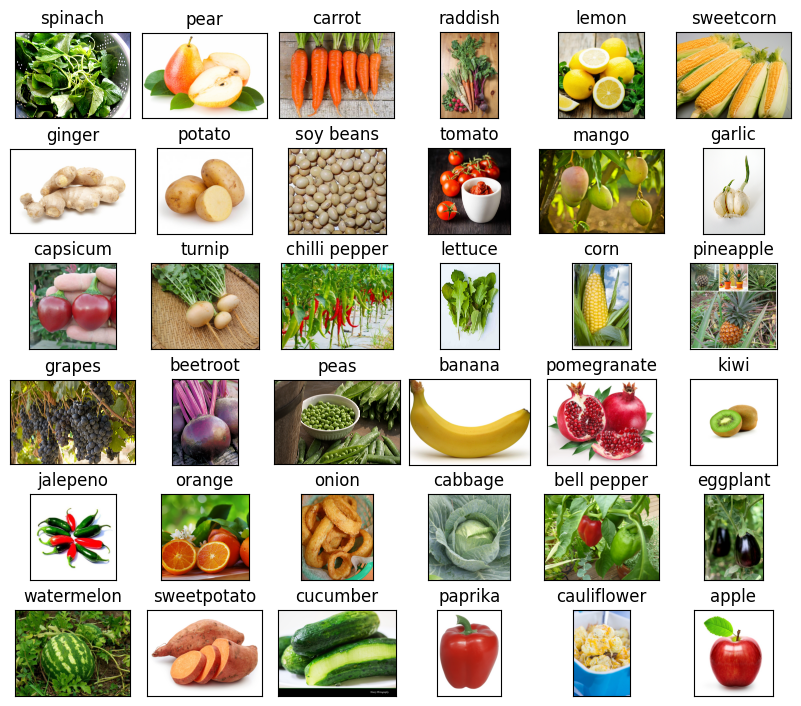

In [43]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## 2. Load the Images with a generator and Data Augmentation

In [45]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 339 validated image filenames belonging to 36 classes.


In [46]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 3. Train the Modal

In [47]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

e:\Fruit-vegetable-classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.3576 - loss: 2.5420 - val_accuracy: 0.8500 - val_loss: 0.4453
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.8239 - loss: 0.5948 - val_accuracy: 0.9471 - val_loss: 0.2653
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.8902 - loss: 0.3406 - val_accuracy: 0.9324 - val_loss: 0.2336
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9256 - loss: 0.2356 - val_accuracy: 0.9324 - val_loss: 0.2111
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.9470 - loss: 0.1662 - val_accuracy: 0.9529 - val_loss: 0.1701


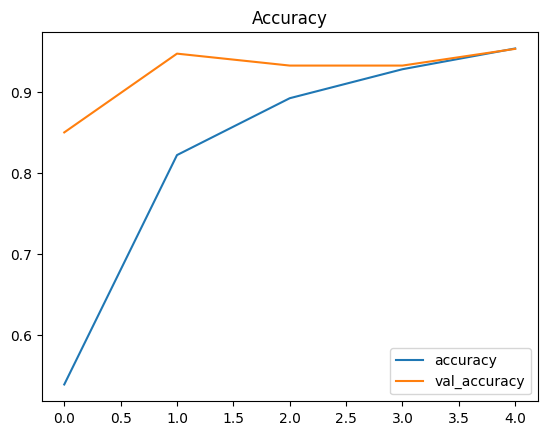

In [48]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

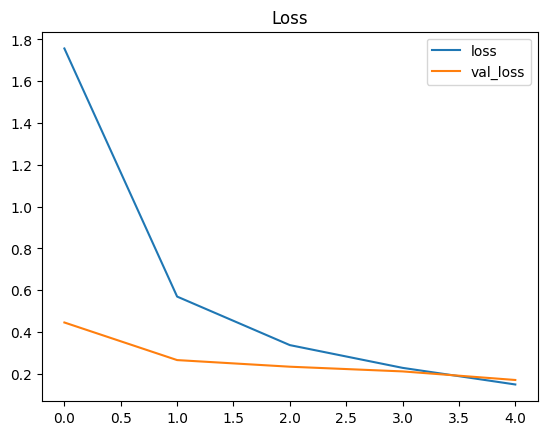

In [49]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()  

## 4. Visualiase the result

In [50]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

e:\Fruit-vegetable-classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


In [51]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.58%


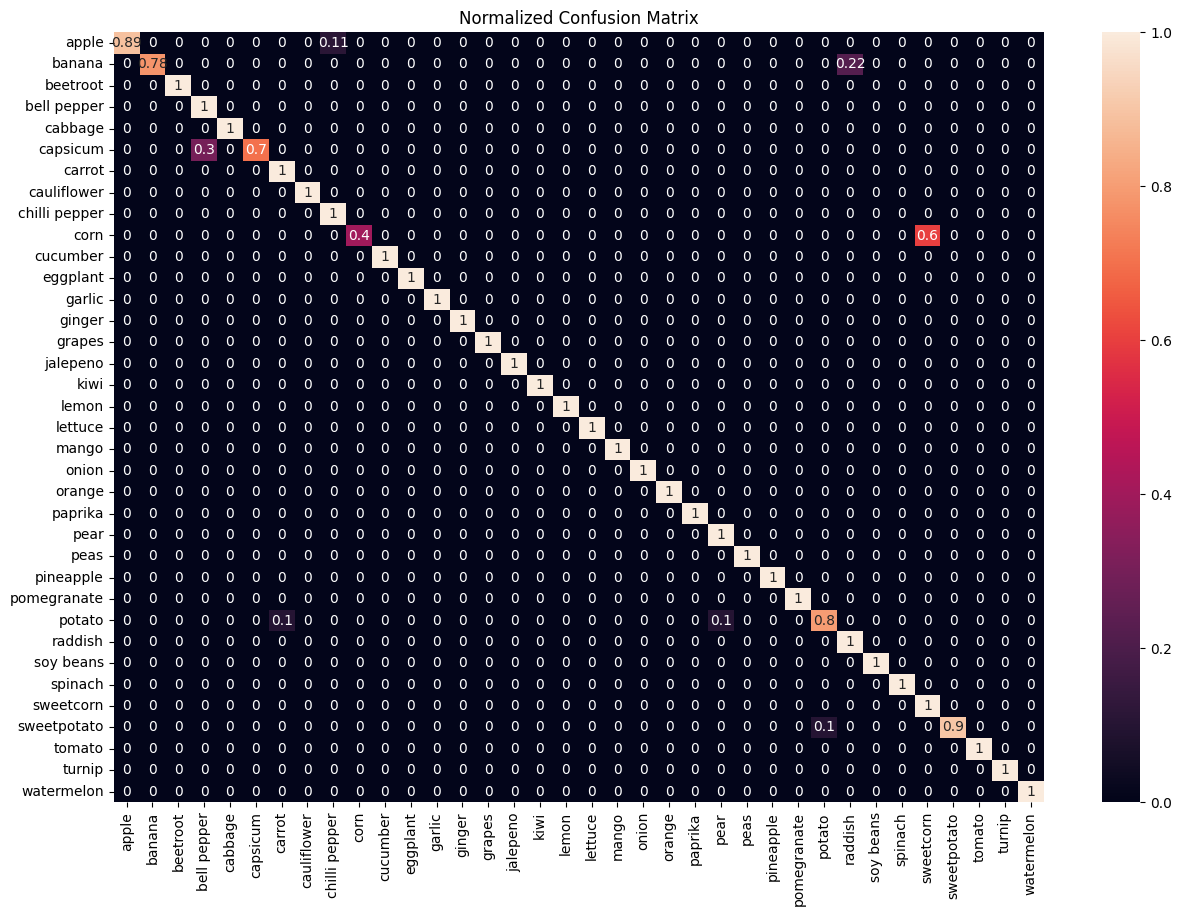

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

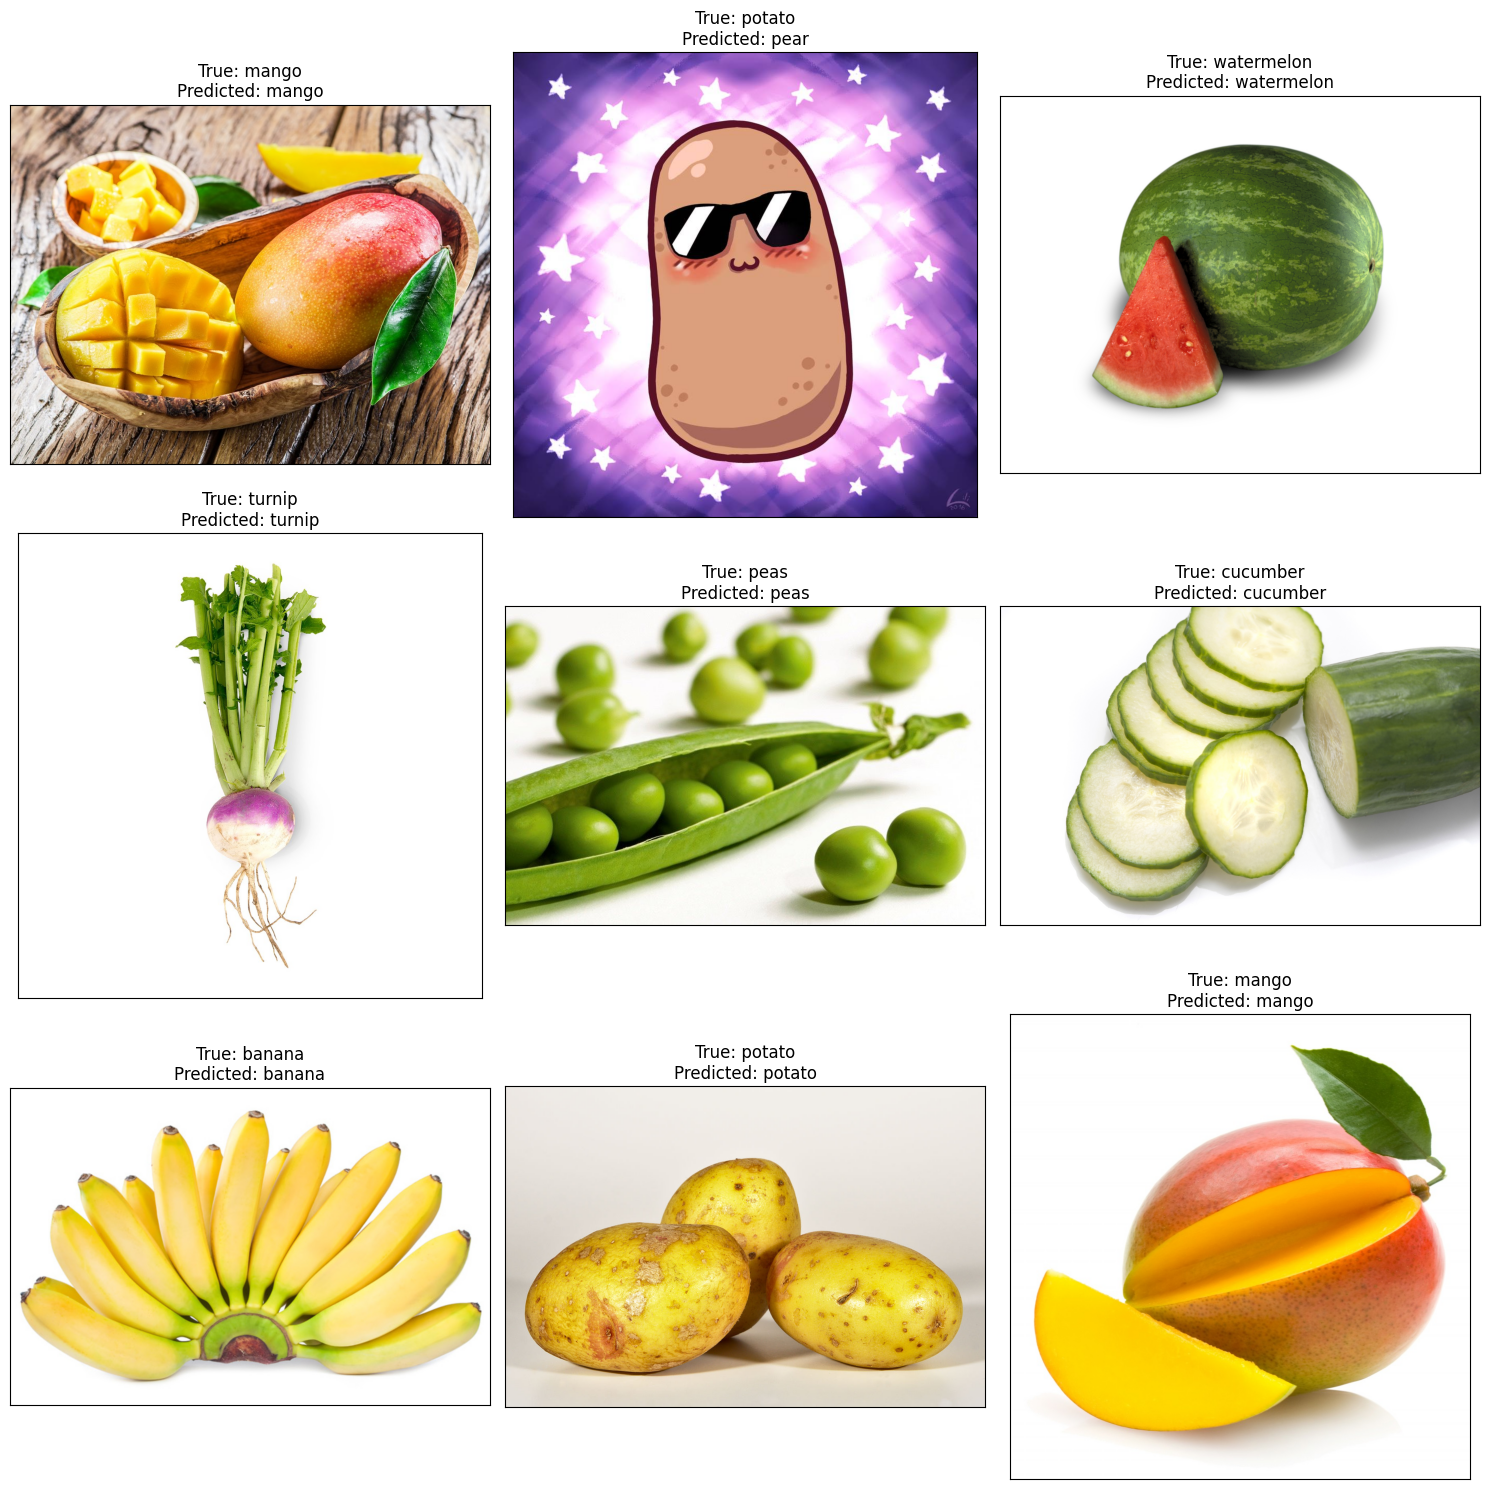

In [54]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [78]:
from PIL import Image

In [79]:
class_names = sorted(train_df['Label'].unique())

In [80]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))  # Change size if your model uses a different input
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize if trained that way
    return img_array


def give_prediction(image_path: str):   
    # Predict
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    print(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")




In [81]:
give_prediction('../1.jfif')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction: onion (68.81% confidence)


In [82]:
model.save('fruit_classificatin_model.keras')